# 高效能Python

對於性能的關鍵應用，總是應該檢查兩件事，我們使用的是正確的數學表達式嗎？我們使用的是正確的高性能library嗎？許多高性能library可以加速Python程式碼的執行，其中下面的Library最為實用
+ Cython，用於合併Python和C語言
+ Ipython.parallel，用於在本地或是cluster上同步執行程式碼
+ numexpr，用於快速的數學運算
+ multiprocessing，Python內建的同步處理模組
+ Numba，用於為CPU動態編譯Python程式碼
+ NumbaPro，用於為多核CPU和GPU動態編譯Python程式碼

我們將比較不同方法但使用相同算法，於是我們定義一個方便的函數

In [1]:
import matplotlib.pyplot as plt
def perf_comp_data(func_list, data_list, rep=3, number=1):
    from timeit import repeat
    res_list = {}
    for name in enumerate(func_list):
        stmt = name[1] + '(' + data_list[name[0]] + ')'
        setup = "from __main__ import " + name[1] + ", " + data_list[name[0]]
        results = repeat(stmt=stmt, setup=setup, repeat=rep, number=number)
        res_list[name[1]] = sum(results)/rep
    # res_sort = sorted(res_list.items(), key=lambda (k, v): (v, k))
    res_sort = sorted(res_list.items())
    for item in res_sort:
        rel = item[1] / res_sort[0][1]
        print('function: ' + item[0] + ', av. time sec: %9.5f, ' % item[1] + 'relative: %6.1f' % rel)

金融學與其他科學一樣，數值計算是相當費時的，如以下例子$$y=\sqrt{\left | cos(x) \right |)} + sin(2 + 3x)$$

In [2]:
from math import *
def f(x):
    return abs(cos(x)) ** 0.5 + sin(2 + 3 * x)

In [3]:
I = 500000
a_py = range(I)

In [4]:
def f1(a):
    res = []
    for x in a:
        res.append(f(x))
    return res

我們試試其他種方式

In [5]:
def f2(a):
    return [f(x) for x in a]

In [6]:
def f3(a):
    ex = 'abs(cos(x)) ** 0.5 + sin(2 + 3 * x)'
    return [eval(ex) for x in a]

In [7]:
import numpy as np
a_np = np.arange(I)
def f4(a):
    return (np.abs(np.cos(a)) ** 0.5 + np.sin(2 + 3 * a))

我們也可以用numexpr求值，這個library內建多執行緒

In [8]:
import numexpr as ne

In [9]:
def f5(a):
    ex = 'abs(cos(a)) ** 0.5 + sin(2 + 3 * a)'
    ne.set_num_threads(1)
    return ne.evaluate(ex)

In [10]:
def f6(a):
    ex = 'abs(cos(a)) ** 0.5 + sin(2 + 3 * a)'
    ne.set_num_threads(4)
    return ne.evaluate(ex)

In [11]:
%%time
r1 = f1(a_py)
r2 = f2(a_py)
r3 = f3(a_py)
r4 = f4(a_np)
r5 = f5(a_np)
r6 = f6(a_np)

CPU times: user 13.4 s, sys: 189 ms, total: 13.6 s
Wall time: 14.4 s


我們使用perf_comp_data函數來個別計算所有函數的計算時間

In [12]:
func_list = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6']
data_list = ['a_py', 'a_py','a_py','a_np','a_np','a_np']

In [13]:
perf_comp_data(func_list, data_list)

function: f1, av. time sec:   0.40219, relative:    1.0
function: f2, av. time sec:   0.36057, relative:    0.9
function: f3, av. time sec:  14.41069, relative:   35.8
function: f4, av. time sec:   0.03337, relative:    0.1
function: f5, av. time sec:   0.02861, relative:    0.1
function: f6, av. time sec:   0.01249, relative:    0.0


### 記憶體佈局與性能

numpy可以為每個ndarray指定dtype，例如np.int32或是f8，還能自訂行優先或列優先的記憶體佈局

In [14]:
np.zeros((3, 3), dtype=np.float64, order='C') #C表示列優先，F表示行優先

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

而佈局的方式可能會對這些數據操作的性能造成很大的影響

In [15]:
c = np.array([[1., 1., 1.],
             [2., 2., 2.],
             [3., 3., 3.]], order='C')

本例中，1, 2, 3相鄰   
那麼行優先

In [16]:
f = np.array([[1., 1., 1.],
             [2., 2., 2.],
             [3., 3., 3.]], order='F')

我們來看看當數據大時，會對記憶體佈局造成什麼樣的差異

In [17]:
x = np.random.standard_normal((3, 1500000))
C = np.array(x, order='C')
F = np.array(x, order='F')
x = 0.0

首先，計算總和

In [18]:
%timeit C.sum(axis=0)

15.7 ms ± 1.59 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
%timeit C.sum(axis=1)

4.25 ms ± 1.3 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
%timeit F.sum(axis=0)

38.7 ms ± 3.98 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
%timeit F.sum(axis=1)

45 ms ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
C = 0.0; F = 0.0

通常，C的佈局會比F快

### 平行計算

期權的蒙特卡洛估值是導致高計算負擔的金融算法之一，作為特例，我們選擇Black-Scholes-Merton設置下的歐式看漲期權價值蒙特卡洛估算函數，在這種設置下，所要估值的期權標的遵循隨機微分方程式$$C_{0} = e^{-rT}\frac{1}{I}\sum max(S_{T}(i)-K,0)$$


In [23]:
def bsm_mcs_valuation(strike):
    import numpy as np
    S0 = 100.
    T = 1.0
    r = 0.05
    vola = 0.2
    M = 50
    I = 20000
    dt = T / M
    rand = np.random.standard_normal((M + 1, I))
    S = np.zeros((M + 1, I))
    S[0] = S0
    for t in range(1, M + 1):
        S[t] = S[t - 1] * np.exp((r - 0.5 * vola ** 2) * dt + vola * np.sqrt(dt) * rand[t])
    value = (np.exp(-r * T) * np.sum(np.maximum(S[-1] - strike, 0))/I)
    return value

順序化計算

作為基準用例，我們對不同行期權的100種期權進行估值。seq_value函數計算蒙特卡洛估算函數

In [24]:
def seq_value(n):
    strikes = np.linspace(80, 120, n)
    option_values = []
    for strike in strikes:
        option_values.append(bsm_mcs_valuation(strike))
    return strikes, option_values

In [25]:
n = 100
%time strikes, option_values_seq = seq_value(n)

CPU times: user 6.31 s, sys: 477 ms, total: 6.79 s
Wall time: 7.54 s


(array([  0.,   5.,  10.,  15.,  20.,  25.,  30.]),
 <a list of 7 Text yticklabel objects>)

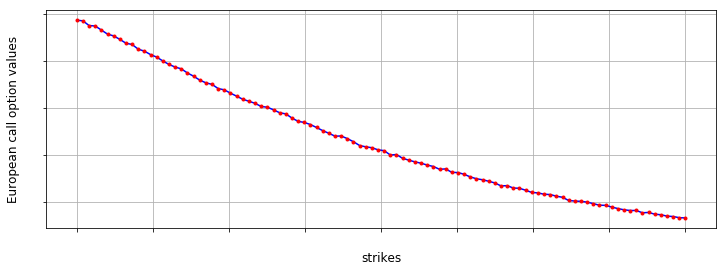

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(12,4))
plt.plot(strikes, option_values_seq, 'b')
plt.plot(strikes, option_values_seq, 'r.')
plt.grid(True)
plt.xlabel('strikes', fontsize='large')
plt.ylabel('European call option values', fontsize='large')
plt.xticks(color='w', fontsize='large')
plt.yticks(color='w', fontsize='large')

平行計算

為了計算100個權證價值，我們使用IPython.paraleel和一個本地的cluster，本地的cluster很容易通過IPython notebook儀表板中的cluster選項啟動，使用執行緒的數量當然取決於硬體和CPU

In [27]:
# from ipyparallel import Client
# c = Client(profile='default')
# view = c.load_balanced_view()

In [28]:
# def par_value(n):
#     strikes = np.linspace(80, 120, n)
#     option_values = []
#     for strike in strikes:
#         value = view.apply_async(bsm_mcs_valuation, strike)
#         option_values.append(value)
#     c.wait(option_values)
#     return strikes, option_values

同步估值函數的執行效率在理想的狀況下和可用的CPU數量呈現線性關係

In [29]:
#%time strikes, option_values_obj = par_value(n)

In [30]:
#option_values_obj[0].metadata

估值結果在result屬性中

In [31]:
#option_values_obj[0].result

In [32]:
# option_values_par = []
# for res in option_values_obj:
#     option_values_par.append(res.result)

In [33]:
# plt.figure(figsize=(12,4))
# plt.plot(strikes, option_values_seq, 'b', label='Sequential')
# plt.plot(strikes, option_values_par, 'r.', label='Parallel')
# plt.grid(True)
# plt.legend(loc=0)
# plt.xlabel('strikes', fontsize='large')
# plt.ylabel('European call option values', fontsize='large')
# plt.xticks(color='w', fontsize='large')
# plt.yticks(color='w', fontsize='large')

多處理

IPython.parallel的優勢是可以在中小規模的cluster上伸縮，但有時候在本地平行執行程式碼是很有益的，這就是標準library multiprocessing的用武之地

In [34]:
import multiprocessing as mp

模擬幾何布朗運動函數

In [35]:
import math
def simulate_geometric_brownian_motion(p):
    M, I = p
    S0 = 100
    r = 0.05
    sigma = 0.2
    T = 1.0
    dt = T / M
    paths = np.zeros((M + 1, I))
    paths[0] = S0
    for t in range(1, M + 1):
        paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * math.sqrt(dt) * np.random.standard_normal(I))
    return paths

這個函數返回以M和I作為參數的模擬路徑

In [36]:
paths = simulate_geometric_brownian_motion((5, 2))
paths

array([[ 100.        ,  100.        ],
       [  88.45640072,   97.61881377],
       [  91.0829885 ,  103.20190924],
       [ 103.84668013,  100.42665007],
       [  99.59182146,   99.07733855],
       [ 104.72869819,  104.54900574]])

In [37]:
I = 10000 # number of paths
M = 100 # number of time steps
t = 100 # number of tasks/simulations

In [38]:
from time import time
times = []
for w in range(1, 8):
    t0 = time()
    pool = mp.Pool(processes=w) #the pool of workers
    result = pool.map(simulate_geometric_brownian_motion, t * [(M, I), ])
    times.append(time() - t0)

我們將再次得出性能與可用CPU數量成正比的結論，不過太多也不好

(array([  5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.]),
 <a list of 8 Text yticklabel objects>)

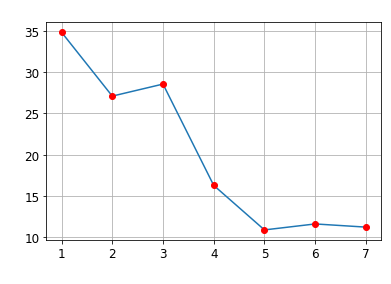

In [39]:
plt.plot(range(1, 8), times)
plt.plot(range(1, 8), times, 'ro')
plt.grid(True)
plt.xlabel('number of processes', color='w', fontsize='large')
plt.ylabel('time in seconds', color='w', fontsize='large')
plt.title('%d Monte Carlo simulations' % t, color='w', fontsize='large')
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')

### 動態編譯

Numba是開源的，他使用LLVM編譯器基礎架構

介紹性範例

In [40]:
from math import cos, log
def f_py(I, J):
    res = 0
    for i in range(I):
        for j in range(J):
            res += int(cos(log(1)))
    return res

In [41]:
I, J = 5000, 5000
%time f_py(I, J)

CPU times: user 12.4 s, sys: 178 ms, total: 12.6 s
Wall time: 13.1 s


25000000

我們還能利用numpy加速

In [42]:
def f_np(I, J):
    a = np.ones((I, J), dtype=np.float64)
    return int(np.sum(np.cos(np.log(a)))), a
                

In [43]:
%time res, a = f_np(I, J)

CPU times: user 552 ms, sys: 279 ms, total: 832 ms
Wall time: 870 ms


這種方法快很多，但是並不能真正高效的利用記憶體

In [44]:
a.nbytes

200000000

考慮到RAM，Numba提供一種有吸引力的替代方法

In [46]:
# if cannot import using python 2
import numba as nb

ImportError: No module named 'numba'

In [ ]:
f_nb = nb.jit(f_py)

In [ ]:
%time f_nb(I, J)

我們系統性的比較

In [ ]:
func_list = ['f_py', 'f_np', 'f_nb']
data_list = 3 * ['I, J']

In [ ]:
perf_comp_data(func_list, data_list)

二項式期權定價方法

風險中立的上漲機率公式如下：$$q = \frac{e^{r\triangle t} - d}{u - d}$$  
並將之參數化

In [ ]:
S0 = 100. # initial index level
T = 1.  # call option maturity
r = 0.05 # constant short rate
vola = 0.2 #constant volatility factor of diffusion

M = 1000 # time steps
dt = T/M # length of time interval
df = exp(-r * dt) # discount factor per time interval

u = exp(vola * sqrt(dt)) # up movement
d = 1/u # down movement
q = (exp(r * dt) - d) / (u-d)

歐式二項期權算法的實現主要包含如下部分：  
+ 指數水平模擬
+ 內在價值計算
+ 風險中性折算

In [ ]:
def binomial_py(strike):
    # Loop1 - Index Levels
    S = np.zeros((M + 1, M + 1), dtype=np.float64)
    S[0, 0] = S0
    z1 = 0
    for j in xrange(1, M + 1, 1):
        z1 = z1 + 1
        for i in xrange(z1 + 1):
            S[i, j] = S[0, 0] * (u ** j) * (d ** (i * 2))
    
    # Loop2 - Inner Values
    iv = np.zeros((M + 1, M + 1), dtype=np.float64)
    z2 = 0
    for j in xrange(0, M + 1, 1):
        for i in xrange(z2 + 1):
            iv[i, j] = max(S[i, j] - strike, 0)
        z2 = z2 + 1
    
    # Loop3 - Valuation
    pv = np.zeros((M + 1, M + 1), dtype = np.float64)
    pv[:, M] = iv[:, M] # initial last time point
    z3 = M + 1
    for j in xrange(M-1, -1, -1):
        z3 = z3 - 1
        for i in xrange(z3):
            pv[i, j] = (q * pv[i, j+1] + (1 - q) * pv[i + 1, j + 1]) * df
    return pv[0, 0]

In [ ]:
%time round(binomial_py(100), 3)

我們可以將這個結果與蒙特卡洛估值函數bsm_mcs_valuation做比較

In [ ]:
%time round(bsm_mcs_valuation(100), 3)

兩個值「相似」因為蒙特卡洛估值所實現的算法不是很準確，但相比之下，較為快速  
我們再使用Numba增速

In [ ]:
binomial_nb = nb.jit(binomial_py)

In [ ]:
%time round(binomial_nb(100), 3)

總而言之，我們可以得出以下結論：
+ 效率：使用Numba只需要花費很少的經歷，你所需要的只是使用jit函數
+ 加速：Numba帶來執行效率顯著提高
+ 記憶體：使用numba不需要初始化大型陣列，編譯器專門為手上的問題生成機器碼，並維持和純python相同的記憶體利用效率

### 用Cython進行靜態編譯

Numba的優勢是對任意函數使用該方法毫不費力，但是，numba只能對某些問題「毫不費力」，另一種方法更為靈活，但也需要較多精力，就是通過cython靜態編譯，Cython是python和C的混血兒

In [47]:
def f_py(I, J):
    res = 0
    for i in range(I):
        for j in range (J * I):
            res += 1
    return res

In [49]:
I, J = 50, 500
%time f_py(I, J)

CPU times: user 148 ms, sys: 5.09 ms, total: 153 ms
Wall time: 187 ms


1250000

接下來，include pyc模組

In [50]:
import pyximport
pyximport.install()

(None, <pyximport.pyximport.PyxImporter at 0x10a33a0b8>)

In [51]:
import sys
sys.path.append('data/')

In [52]:
# if error, using python3
from nested_loop import f_cy

In [53]:
%time res = f_cy(I, J)

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 8.82 µs


In [54]:
res

1250000

在iPython notebook中工作時，使用Cython有一個更便利的方法

In [55]:
%load_ext Cython

In [56]:
%%cython
def f_cy(int I, int J):
    cdef int res = 0
    for i in range(I):
        for j in range(J * I):
            res += 1
    return res

In [57]:
%time res = f_cy(I, J)

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 12.2 µs


In [58]:
res

1250000

我們再回頭試試看numba

In [ ]:
f_nb = nb.jit(f_py)

In [ ]:
%time res = f_nb(I, J)

In [ ]:
res

In [ ]:
func_list = ['f_py', 'f_cy','f_nb']
I, J = 50, 500
data_list = 3 * ['I, J']

In [ ]:
perf_comp_data(func_list, data_list)